#library

In [ ]:
!pip install keras-visualizer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import cv2
import glob
import random
import tensorflow
import numpy as np
from sklearn import svm
from keras import layers
from keras import models
from skimage import feature
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.python import image
from keras.utils import to_categorical
from keras_visualizer import visualizer 
from keras.layers.core.dense import Dense
from sklearn.metrics import accuracy_score
from keras.utils.vis_utils import plot_model
from tensorflow.python.ops.math_ops import add
from keras.engine.sequential import Sequential
from sklearn.preprocessing import LabelEncoder
from keras.layers.serialization import activation
from tensorflow.python.ops.math_ops import Sigmoid
from sklearn.model_selection import train_test_split
from keras.layers.convolutional.base_separable_conv import activations

In [ ]:
def show(image, cmap=None):
  plt.imshow(image, cmap=cmap)
  plt.show()

In [ ]:
def find_contour(image):
  blurred = cv2.GaussianBlur(image,(3,3), 0)
  gray = cv2.cvtColor(blurred, cv2.COLOR_BGR2GRAY)
  # show(gray, 'gray')

  # thresh = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY)[1]
  # thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 111, 10)
  thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]
  # show(thresh, 'gray')

  structural_element = np.ones((4, 4))
  open = cv2.erode(thresh, structural_element)
  # show(open, 'gray')

  structural_element = np.ones((7, 7))
  close = cv2.morphologyEx(open, cv2.MORPH_CLOSE, structural_element)
  # show(close, 'gray')

  structural_element = np.ones((3, 3))
  open = cv2.morphologyEx(close, cv2.MORPH_OPEN, structural_element)
  # show(open, 'gray')

  # structural_element = np.ones((20, 30))
  close = cv2.morphologyEx(open, cv2.MORPH_CLOSE, structural_element)
  # show(close, 'gray')

  cnts, hierarchy = cv2.findContours(close.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  cnt = max(cnts, key=cv2.contourArea)
  # cnt1 = max(cnts, key=len)
  
  # img = image.copy()
  # cv2.drawContours(img, [cnt1], -1, (0,255,0), 1)
  # cv2.drawContours(img, [cnt], -1, (255,0,0), 1)
  # show(img)

  return cnt

#Part1.compatness

In [ ]:
def compatness(image):
  cnt = find_contour(image)
  area = cv2.contourArea(cnt)
  perimeter = cv2.arcLength(cnt, closed=True)
  compactness_score = (4 * np.pi * float(area)) / (perimeter**2)
  return compactness_score

#Part2.eccenticity

In [ ]:
def eccenticity(image):
  cnt = find_contour(image)
  (x,y), (ma,MA), angle = cv2.fitEllipse(cnt)
  eccentricity_score = np.sqrt(1 - (ma / MA)**2)
  return eccentricity_score

#Part3.solidity

In [ ]:
def solidity(image):
  cnt = find_contour(image)
  area = cv2.contourArea(cnt)
  hull = cv2.convexHull(cnt)
  hull_area = cv2.contourArea(hull)
  solidity_score = float(area) / hull_area
  return solidity_score

#Part4.LBP

In [ ]:
def histogram_of_LBP(image, numPoints, radius, eps=1e-7):
	gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
 
	bins = np.arange(0, numPoints + 3)
	range = (0, numPoints + 2)
	lbp = feature.local_binary_pattern(gray, numPoints, radius, "uniform")
	hist_values, _ = np.histogram(lbp.ravel(), bins=bins, range=range)

 	# normalize the histogram
	hist_values = hist_values.astype("float")
	hist_values /= (hist_values.sum() + eps)
 
	return hist_values

#validate function

In [ ]:
def validating_func(image_ship_path, image_airplane_path):
  ship_img = cv2.imread(image_ship_path)
  airplane_img = cv2.imread(image_airplane_path)
  eccenticity_ship, eccenticity_airplane = eccenticity(ship_img), eccenticity(airplane_img)
  compatness_ship, compatness_airplane = compatness(ship_img), compatness(airplane_img)
  solidity_ship, solidity_airplane = solidity(ship_img), solidity(airplane_img)
  print(f"Result for ship image:\ncompatness is : {compatness_ship}\t\teccenticity is : {eccenticity_ship}\t\tsolidity is : {solidity_ship}")
  print(f"Result for airplane image:\ncompatness is : {compatness_airplane}\t\teccenticity is : {eccenticity_airplane}\t\tsolidity is : {solidity_airplane}")
  

#Part5.prepare dataset(just run this cell and not change)

In [ ]:
!gdown --id 1O_VkcGlWRR6h00VT8nXIgeI3RyvBpXbE
!unzip dataset.zip
classes = os.listdir("/content/dataset")
images_paths = glob.glob("/content/dataset/*/*")

/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1O_VkcGlWRR6h00VT8nXIgeI3RyvBpXbE
To: /content/dataset.zip
100% 18.4M/18.4M [00:00<00:00, 159MB/s]
Archive:  dataset.zip
   creating: dataset/
   creating: dataset/airplane/
  inflating: dataset/airplane/airplane1.jpg  
  inflating: dataset/airplane/airplane136.jpg  
  inflating: dataset/airplane/airplane14.jpg  
  inflating: dataset/airplane/airplane141.jpg  
  inflating: dataset/airplane/airplane153.jpg  
  inflating: dataset/airplane/airplane156.jpg  
  inflating: dataset/airplane/airplane157.jpg  
  inflating: dataset/airplane/airplane159.jpg  
  inflating: dataset/airplane/airplane169.jpg  
  inflating: dataset/airplane/airplane170.jpg  
  inflating: dataset/airplane/airplane182.jpg  
  inflating: dataset/airplane/airp

In [72]:
image_ship_path = 'dataset/ship/1603853.jpg'
image_airplane_path = 'dataset/airplane/airplane325.jpg'
validating_func(image_ship_path, image_airplane_path)

Result for ship image:
compatness is : 0.6817744565013821		eccenticity is : 0.981031097066142		solidity is : 0.9831235697940504
Result for airplane image:
compatness is : 0.1846583078551962		eccenticity is : 0.7420817333011284		solidity is : 0.8883087170918774


In [ ]:
x_data , y_data = [], []
for img_path in images_paths:
  x_data.append(cv2.resize(cv2.imread(img_path), (224,224)))
  if img_path.split("/")[3] == "ship":
    y_data.append(0)
  else:
    y_data.append(1)  

In [ ]:
 x_train, x_test, y_train, y_test = train_test_split(x_data, y_data,test_size = 0.2, shuffle= True)

#Part6. Exctract features and determine classifier

In [61]:
print(len(histogram_of_LBP(x_train[0], 8, 1)))

10


In [ ]:
def get_featureMatrix(data):
  feature_matrix = [
      [
        compatness(image), 
        eccenticity(image), 
        solidity(image)
      ]+[*histogram_of_LBP(image, 8, 1)]
      for image in data
  ]
  return np.array(feature_matrix)


In [ ]:
# model 1
feature_matrix_train = get_featureMatrix(x_train)
print(feature_matrix_train.shape)

#determine classifier and train 
clf = svm.LinearSVC()
clf.fit(feature_matrix_train, y_train)

(254, 13)


LinearSVC()

#Part7

In [ ]:
#test on test dataset
feature_matrix_test = get_featureMatrix(x_test)
predicted_labels = clf.predict(feature_matrix_test)
accuracy = accuracy_score(y_test, predicted_labels)
print('accuracy:', accuracy*100, '%')

accuracy: 87.5 %


#Part8

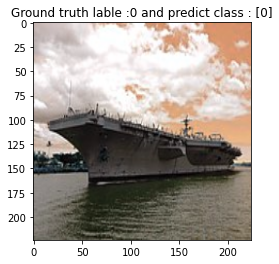

In [ ]:
#test visualize
index = random.randint(0, len(x_test)-1)
prediction = clf.predict(get_featureMatrix(np.array([x_test[index]])))
plt.title(f"Ground truth lable :{y_test[index]} and predict class : {prediction}")
plt.imshow(x_test[index])
plt.show()